In [1]:
import sys
import random
from pathlib import Path
import json

# Ajustar la ruta para que Python reconozca 'src'
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config import MIDI_DIR, WAV_DIR, JAMS_DIR, DEFAULT_TEMPO
from src.generate_progression import generate_progression
from src.audio_conversion import convert_all_mid_in_folder
from src.jams_creation import create_jams_for_folder

print("MIDI_DIR =", MIDI_DIR)
print("WAV_DIR  =", WAV_DIR)
print("JAMS_DIR =", JAMS_DIR)
print("DEFAULT_TEMPO =", DEFAULT_TEMPO)


MIDI_DIR = /home/cepatinog/MIR/final_project/chord_progression_generator/data2/midi
WAV_DIR  = /home/cepatinog/MIR/final_project/chord_progression_generator/data2/wav
JAMS_DIR = /home/cepatinog/MIR/final_project/chord_progression_generator/data2/jams
DEFAULT_TEMPO = 60


In [2]:

# ==========================
# 2. Definir Progresiones
# ==========================

# Sufijos del diccionario
chord_suffixes = [
    "min", "maj", "dim", "aug",
    "min6", "maj6", "min7", "minmaj7",
    "maj7", "7", "dim7", "hdim7",
    "sus2", "sus4"
]

# Bases de 3 acordes
progression_bases_3 = [
    ("I", "IV", "V"),
    ("ii", "V", "I"),
    ("vii", "III", "VI"),
]

# # Bases de 4 acordes
# progression_bases_4 = [
#     ("ii", "V", "I", "IV"),
#     ("iii", "vi", "vii", "II"),
# ]

In [3]:
# ==========================
# 3. Crear combos aleatorios
# ==========================

def random_suffix_combos(num_chords: int, suffix_list, sample_size=20):
    """
    Retorna una lista de tuplas, cada tupla contiene 'num_chords' sufijos.
    Excluimos la tupla si TODOS los sufijos son iguales.
    Muestreamos sample_size combos aleatorios sin reemplazo.
    """
    import itertools

    # Generar todas las combinaciones cartesianas
    # p.ej. si num_chords=3 => 14^3 combos
    all_combos = list(itertools.product(suffix_list, repeat=num_chords))

    # Filtrar combos que tengan todos los sufijos iguales
    filtered = [c for c in all_combos if not all(s == c[0] for s in c)]

    # Ajustar sample_size si excede
    if sample_size > len(filtered):
        sample_size = len(filtered)

    # Seleccionar sample_size combos aleatorios
    combos = random.sample(filtered, sample_size)
    return combos


In [4]:
# --- 3) Generar .mid para las progresiones base (3 y 4 acordes) ---

def generate_all_mid():
    # EJEMPLO: para 3 acordes, tomamos 15 combos aleatorios
    for base_3 in progression_bases_3:
        combos_3 = random_suffix_combos(num_chords=3, suffix_list=chord_suffixes, sample_size=5)
        for combo in combos_3:
            # Construir algo p.ej. "I,maj - IV,min - V,7"
            prog_str = "-".join(f"{g},{suf}" for g, suf in zip(base_3, combo))
            folder_name = f"rand3_{'-'.join(base_3)}_{'_'.join(combo)}"
            generate_progression(prog_str, folder_name, MIDI_DIR, DEFAULT_TEMPO)
    
    # # Para 4 acordes, tomamos 10 combos aleatorios (por ejemplo)
    # for base_4 in progression_bases_4:
    #     combos_4 = random_suffix_combos(num_chords=4, suffix_list=chord_suffixes, sample_size=10)
    #     for combo in combos_4:
    #         prog_str = "-".join(f"{g},{suf}" for g, suf in zip(base_4, combo))
    #         folder_name = f"rand4_{'-'.join(base_4)}_{'_'.join(combo)}"
    #         generate_progression(prog_str, folder_name, MIDI_DIR, DEFAULT_TEMPO)

# Generar
generate_all_mid()

Generated progression 'I,min-IV,sus4-V,sus2' -> folder: /home/cepatinog/MIR/final_project/chord_progression_generator/data2/midi/rand3_I-IV-V_min_sus4_sus2
Generated progression 'I,aug-IV,sus2-V,sus4' -> folder: /home/cepatinog/MIR/final_project/chord_progression_generator/data2/midi/rand3_I-IV-V_aug_sus2_sus4
Generated progression 'I,aug-IV,7-V,min' -> folder: /home/cepatinog/MIR/final_project/chord_progression_generator/data2/midi/rand3_I-IV-V_aug_7_min
Generated progression 'I,min-IV,hdim7-V,minmaj7' -> folder: /home/cepatinog/MIR/final_project/chord_progression_generator/data2/midi/rand3_I-IV-V_min_hdim7_minmaj7
Generated progression 'I,min6-IV,minmaj7-V,min6' -> folder: /home/cepatinog/MIR/final_project/chord_progression_generator/data2/midi/rand3_I-IV-V_min6_minmaj7_min6
Generated progression 'ii,sus4-V,aug-I,7' -> folder: /home/cepatinog/MIR/final_project/chord_progression_generator/data2/midi/rand3_ii-V-I_sus4_aug_7
Generated progression 'ii,min-V,maj6-I,sus2' -> folder: /home/

In [5]:
def parse_mid_filename(base_name: str):
    """
    Ejem: 'A-2-rand3_ii-V-I_dim7_min7_min-1'
    1) note_oct = 'A-2'
    2) remainder = 'rand3_ii-V-I_dim7_min7_min-1'
    """
    parts = base_name.split("-", 2)  
    if len(parts) < 3:
        print(f"[WARN] {base_name} no tiene formato esperado (nota-oct-randX...).")
        return None

    note_str = parts[0]  # 'A'
    oct_str  = parts[1]  # '2'
    remainder = parts[2] # 'rand3_ii-V-I_dim7_min7_min-1'

    # Extraer index final con rsplit('-',1)
    remainder_parts = remainder.rsplit("-", 1)
    if len(remainder_parts) < 2:
        print(f"[WARN] '{base_name}' no tiene '-<index>' al final.")
        return None

    middle_str = remainder_parts[0]  # 'rand3_ii-V-I_dim7_min7_min'
    idx_str    = remainder_parts[1]  # '1'

    try:
        inversion_index = int(idx_str)
    except:
        print(f"[WARN] Index '{idx_str}' no es entero.")
        inversion_index = 0

    # Partimos 'rand3_ii-V-I_dim7_min7_min' => ["rand3","ii-V-I","dim7_min7_min"]
    mid_parts = middle_str.split("_", 2)
    if len(mid_parts) < 3:
        print(f"[WARN] {middle_str} no sigue 'randX_base_sufijos'.")
        return None

    rand_part = mid_parts[0]  # 'rand3'
    base_part = mid_parts[1]  # 'ii-V-I'
    sufs_part = mid_parts[2]  # 'dim7_min7_min'

    if rand_part.startswith("rand3"):
        num_chords = 3
    elif rand_part.startswith("rand4"):
        num_chords = 4
    else:
        num_chords = 0

    base_chords = base_part.split("-")
    suffixes = sufs_part.split("_")

    if len(base_chords) != num_chords or len(suffixes) != num_chords:
        print(f"[WARN] mismatch #grados={len(base_chords)} y #sufs={len(suffixes)} vs {num_chords}")
        return None

    return {
        "note": note_str,
        "octave": oct_str,
        "base_chords": base_chords,
        "suffixes": suffixes,
        "inversion_index": inversion_index
    }


from src.jams_creation import create_jams_file

def parse_and_create_jams_in_folder(folder: Path):
    """
    1) lee durations.json
    2) itera cada .mid en la carpeta
       - parsea nombre
       - construye roman_sequence
       - llama create_jams_file con duraciones
    """
    durations_path = folder / "durations.json"
    if durations_path.exists():
        with open(durations_path, "r") as f:
            durations_dict = json.load(f)
    else:
        durations_dict = {}

    mid_files = list(folder.rglob("*.mid"))
    if not mid_files:
        print(f"No hay .mid en => {folder}")
        return

    for mf in mid_files:
        base_name = mf.stem  # e.g. "A-2-rand3_ii-V-I_dim7_min7_min-1"
        parsed = parse_mid_filename(base_name)
        if not parsed:
            continue

        base_chords = parsed["base_chords"]
        suffixes    = parsed["suffixes"]
        if len(base_chords) != len(suffixes):
            print(f"[WARN] chords != suffixes in {mf.name}")
            continue

        # p.ej. ['ii,dim7','V,min7','I,min']
        roman_sequence = [f"{g},{s}" for g,s in zip(base_chords, suffixes)]

        # Duraciones
        durations = durations_dict.get(f"{base_name}.mid", None)

        # Tonalidad
        note_tonality = parsed["note"]  # e.g. "A" (podrías parsear algo más si quisieras)

        jam_path = create_jams_file(
            roman_sequence=roman_sequence,
            key=note_tonality,
            jam_name=base_name,
            progression_name="-".join(roman_sequence),
            durations=durations
        )
        print(f"[JAMS] {mf.name} => {jam_path.name}")

def create_jams_all_folders():
    """
    Recorre MIDI_DIR, y para cada carpeta con .mid,
    llama parse_and_create_jams_in_folder
    """
    for p in MIDI_DIR.iterdir():
        if p.is_dir():
            parse_and_create_jams_in_folder(p)

create_jams_all_folders()
print("Generación de .jams completada.")


[JAMS] Bb-5-rand3_vii-III-VI_hdim7_min7_aug-22.mid => Bb-5-rand3_vii-III-VI_hdim7_min7_aug-22.jams
[JAMS] F-3-rand3_vii-III-VI_hdim7_min7_aug-0.mid => F-3-rand3_vii-III-VI_hdim7_min7_aug-0.jams
[JAMS] E-3-rand3_vii-III-VI_hdim7_min7_aug-31.mid => E-3-rand3_vii-III-VI_hdim7_min7_aug-31.jams
[JAMS] F-2-rand3_vii-III-VI_hdim7_min7_aug-7.mid => F-2-rand3_vii-III-VI_hdim7_min7_aug-7.jams
[JAMS] Bb-5-rand3_vii-III-VI_hdim7_min7_aug-50.mid => Bb-5-rand3_vii-III-VI_hdim7_min7_aug-50.jams
[JAMS] A-5-rand3_vii-III-VI_hdim7_min7_aug-56.mid => A-5-rand3_vii-III-VI_hdim7_min7_aug-56.jams
[JAMS] C#-5-rand3_vii-III-VI_hdim7_min7_aug-19.mid => C#-5-rand3_vii-III-VI_hdim7_min7_aug-19.jams
[JAMS] G-2-rand3_vii-III-VI_hdim7_min7_aug-36.mid => G-2-rand3_vii-III-VI_hdim7_min7_aug-36.jams
[JAMS] Bb-4-rand3_vii-III-VI_hdim7_min7_aug-26.mid => Bb-4-rand3_vii-III-VI_hdim7_min7_aug-26.jams
[JAMS] F#-5-rand3_vii-III-VI_hdim7_min7_aug-2.mid => F#-5-rand3_vii-III-VI_hdim7_min7_aug-2.jams
[JAMS] Ab-3-rand3_vii-III-

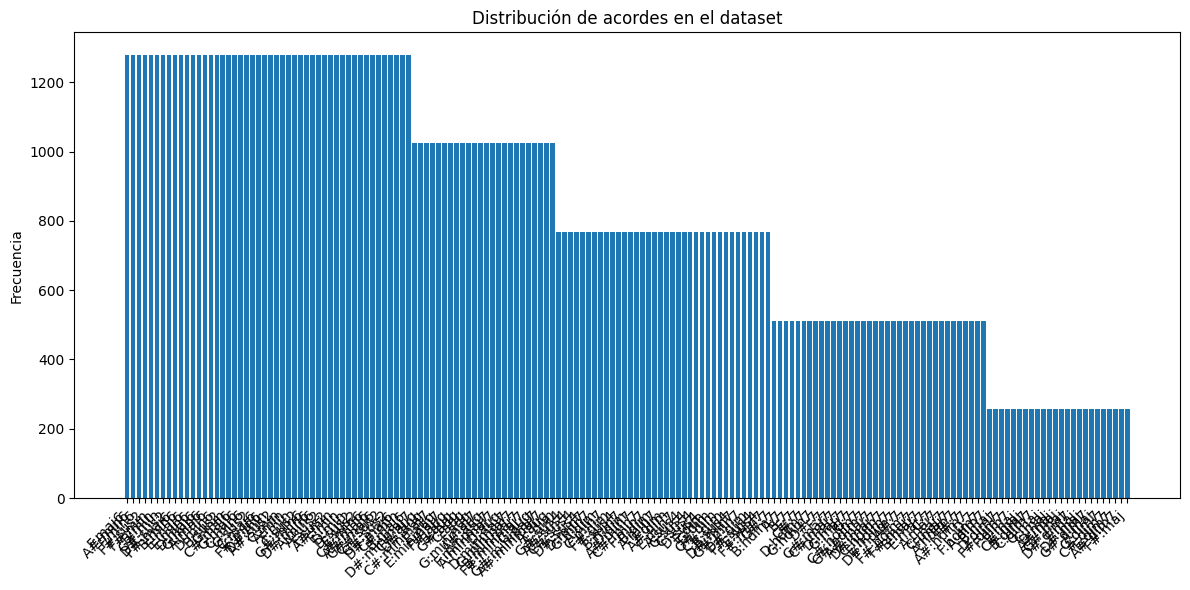

Acordes más frecuentes:
F:maj6   → 1280
A#:min6  → 1280
F:min6   → 1280
F#:sus2  → 1280
F#:min   → 1280
B:min    → 1280
G#:min   → 1280
D#:sus2  → 1280
F#:maj6  → 1280
B:min6   → 1280
E:maj6   → 1280
E:min6   → 1280
D:maj6   → 1280
G:min6   → 1280
A:maj6   → 1280
D:min6   → 1280
B:sus2   → 1280
G:min    → 1280
C#:maj6  → 1280
G:maj6   → 1280
C:min6   → 1280
G:sus2   → 1280
C:maj6   → 1280
F#:min6  → 1280
D#:min   → 1280
A#:sus2  → 1280
C:min    → 1280
A:min    → 1280
F:min    → 1280
C:sus2   → 1280
G#:min6  → 1280
D#:min6  → 1280
A:min6   → 1280
A:sus2   → 1280
F:sus2   → 1280
A#:min   → 1280
E:min    → 1280
D:min    → 1280
D:sus2   → 1280
E:sus2   → 1280
C#:min6  → 1280
A#:maj6  → 1280
G#:maj6  → 1280
C#:sus2  → 1280
G#:sus2  → 1280
D#:maj6  → 1280
C#:min   → 1280
B:maj6   → 1280
D#:minmaj7 → 1024
C#:aug   → 1024
D#:aug   → 1024
C#:minmaj7 → 1024
E:aug    → 1024
E:minmaj7 → 1024
F#:aug   → 1024
B:aug    → 1024
G#:aug   → 1024
C:aug    → 1024
F:aug    → 1024
G:minmaj7 → 1024
A#:aug   →

In [6]:
from pathlib import Path
import json
import collections
import matplotlib.pyplot as plt

def analyze_jams_chord_distribution(jams_folder: Path, top_k: int = None):
    """
    Visualiza la distribución de acordes (ej. 'A:min6') en archivos .jams de una carpeta.
    
    Args:
        jams_folder (Path): carpeta donde están los archivos .jams
        top_k (int): si se indica, muestra solo los K acordes más frecuentes
    """
    chord_counter = collections.Counter()
    jam_files = list(jams_folder.rglob("*.jams"))
    if not jam_files:
        print(f"[WARN] No hay archivos .jams en {jams_folder}")
        return

    # Recorremos cada archivo .jams
    for jam_path in jam_files:
        try:
            with open(jam_path, "r") as f:
                jam_data = json.load(f)
        except Exception as e:
            print(f"[ERROR] {jam_path.name} no se pudo leer: {e}")
            continue

        # Buscar anotaciones en namespace 'chord'
        annotations = jam_data.get("annotations", [])
        for ann in annotations:
            if ann.get("namespace") == "chord":
                for entry in ann.get("data", []):
                    chord = entry.get("value")
                    if chord:
                        chord_counter[chord] += 1

    if not chord_counter:
        print("[INFO] No se encontraron acordes.")
        return

    # Ordenar por frecuencia
    sorted_items = chord_counter.most_common(top_k)

    labels = [label for label, _ in sorted_items]
    counts = [count for _, count in sorted_items]

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, counts)
    plt.title("Distribución de acordes en el dataset")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Mostrar valores
    print("Acordes más frecuentes:")
    for label, count in sorted_items:
        print(f"{label:8s} → {count}")

# Ejemplo de uso
JAMS_FOLDER = Path("/home/cepatinog/MIR/final_project/chord_progression_generator/data2/jams")  # <--- CAMBIA ESTA RUTA
analyze_jams_chord_distribution(JAMS_FOLDER, top_k=168)


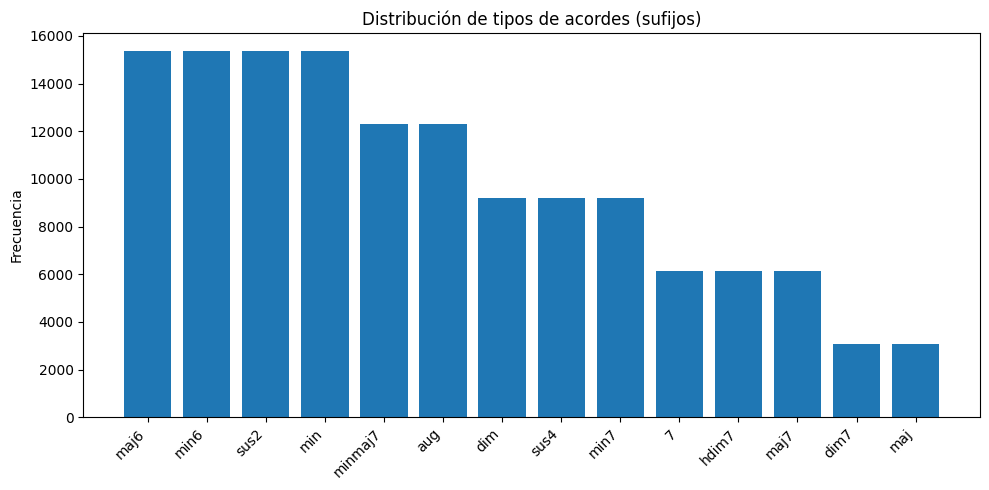

Tipos de acorde más frecuentes:
maj6     → 15360
min6     → 15360
sus2     → 15360
min      → 15360
minmaj7  → 12288
aug      → 12288
dim      → 9216
sus4     → 9216
min7     → 9216
7        → 6144
hdim7    → 6144
maj7     → 6144
dim7     → 3072
maj      → 3072


In [7]:
from pathlib import Path
import json
import collections
import matplotlib.pyplot as plt

def analyze_jams_suffix_distribution(jams_folder: Path, top_k: int = None):
    """
    Visualiza la distribución de tipos de acordes (ej. 'min', 'maj7') en archivos .jams.

    Args:
        jams_folder (Path): Carpeta donde están los archivos .jams
        top_k (int): Si se indica, muestra solo los K sufijos más frecuentes
    """
    suffix_counter = collections.Counter()
    jam_files = list(jams_folder.rglob("*.jams"))
    if not jam_files:
        print(f"[WARN] No hay archivos .jams en {jams_folder}")
        return

    for jam_path in jam_files:
        try:
            with open(jam_path, "r") as f:
                jam_data = json.load(f)
        except Exception as e:
            print(f"[ERROR] {jam_path.name} no se pudo leer: {e}")
            continue

        annotations = jam_data.get("annotations", [])
        for ann in annotations:
            if ann.get("namespace") == "chord":
                for entry in ann.get("data", []):
                    full_chord = entry.get("value")
                    if full_chord and ":" in full_chord:
                        _, suffix = full_chord.split(":", 1)  # p.ej. "A:min7" -> "min7"
                        suffix_counter[suffix] += 1

    if not suffix_counter:
        print("[INFO] No se encontraron acordes.")
        return

    # Ordenar y seleccionar top_k
    sorted_items = suffix_counter.most_common(top_k)

    labels = [label for label, _ in sorted_items]
    counts = [count for _, count in sorted_items]

    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.title("Distribución de tipos de acordes (sufijos)")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Mostrar valores en texto
    print("Tipos de acorde más frecuentes:")
    for label, count in sorted_items:
        print(f"{label:8s} → {count}")

# Ejemplo de uso:
JAMS_FOLDER = Path("/home/cepatinog/MIR/final_project/chord_progression_generator/data2/jams")  # <-- CAMBIA ESTA RUTA
analyze_jams_suffix_distribution(JAMS_FOLDER, top_k=20)
